# Preprocessing

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Pre-processing of the global data 
1. Remove any nan values 
2. Remove any entries before 1850 
3. Remove any attributes, that are not needed 

### Monthly CSV

In [30]:
# Load the data
global_data = pd.read_csv('./raw/GlobalTemperatures.csv')

# Remove all values where dt < 1850:
global_data = global_data[global_data.dt >= '1850-01-01']

# Remove the columns: LandAverageTemperature, LandAverageTemperatureUncertainty,LandMaxTemperature, LandMaxTemperatureUncertainty, LandMinTemperature, LandMinTemperatureUncertainty
global_data = global_data.drop(['LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty'], axis=1)

# Save the data in the processed folder as a csv file with the name global_temperatures_date.csv
global_data.to_csv('./processed/global_temperatures_monthly.csv', index=False)

# Show head of the data
global_data.head()

,dt,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1200,1850-01-01,12.833,0.367
1201,1850-02-01,13.588,0.414
1202,1850-03-01,14.043,0.341
1203,1850-04-01,14.667,0.267
1204,1850-05-01,15.507,0.249


## Prediction using Sarima

In [3]:
# Needed for Sarima:
!pip install pmdarima

     |████████████████████████████████| 580 kB 1.8 MB/s eta 0:00:01
  Using cached statsmodels-0.13.5-cp39-cp39-macosx_11_0_arm64.whl (9.2 MB)
     |████████████████████████████████| 140 kB 80.2 MB/s eta 0:00:01
  Using cached Cython-0.29.32-py2.py3-none-any.whl (986 kB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
You should consider upgrading via the '/Users/dennisshushack/Documents/IVDApreprocessing/env/bin/python3 -m pip install --upgrade pip' command.


In [4]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import datetime

In [8]:
global_data.head(5)

,dt,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1200,1850-01-01,12.833,0.367
1201,1850-02-01,13.588,0.414
1202,1850-03-01,14.043,0.341
1203,1850-04-01,14.667,0.267
1204,1850-05-01,15.507,0.249


In [9]:
# Set index to dt
global_data = global_data.set_index('dt')
global_data.index = pd.to_datetime(global_data.index, format='%Y-%m-%d') 
global_data.head(5)

,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,
1850-01-01,12.833,0.367
1850-02-01,13.588,0.414
1850-03-01,14.043,0.341
1850-04-01,14.667,0.267
1850-05-01,15.507,0.249


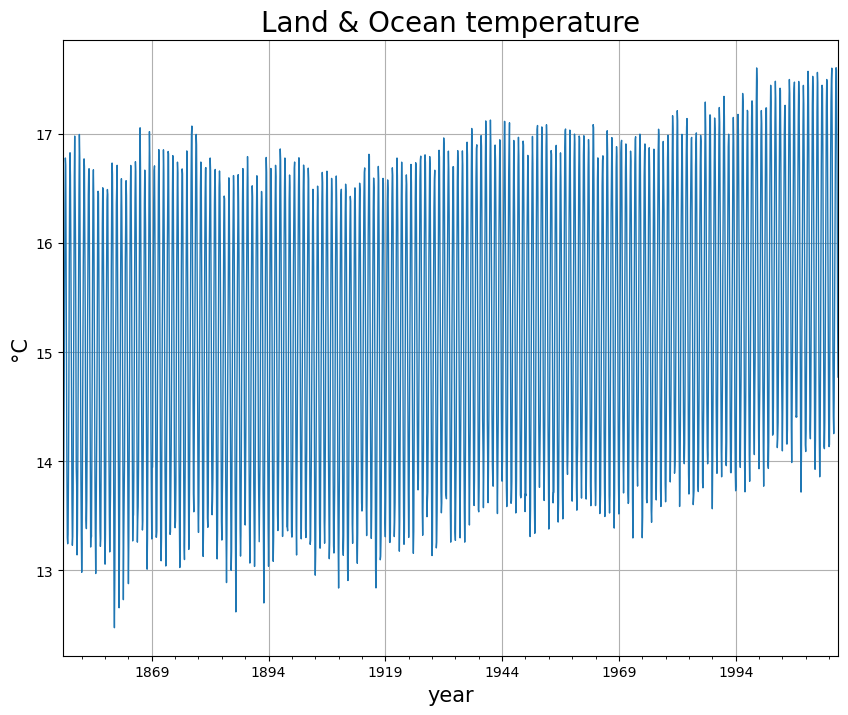

In [10]:
# Get the average temperature for each year and plot the global trend from 1850 year
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
global_data["LandAndOceanAverageTemperature"].plot(linewidth=1)
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.grid(True)

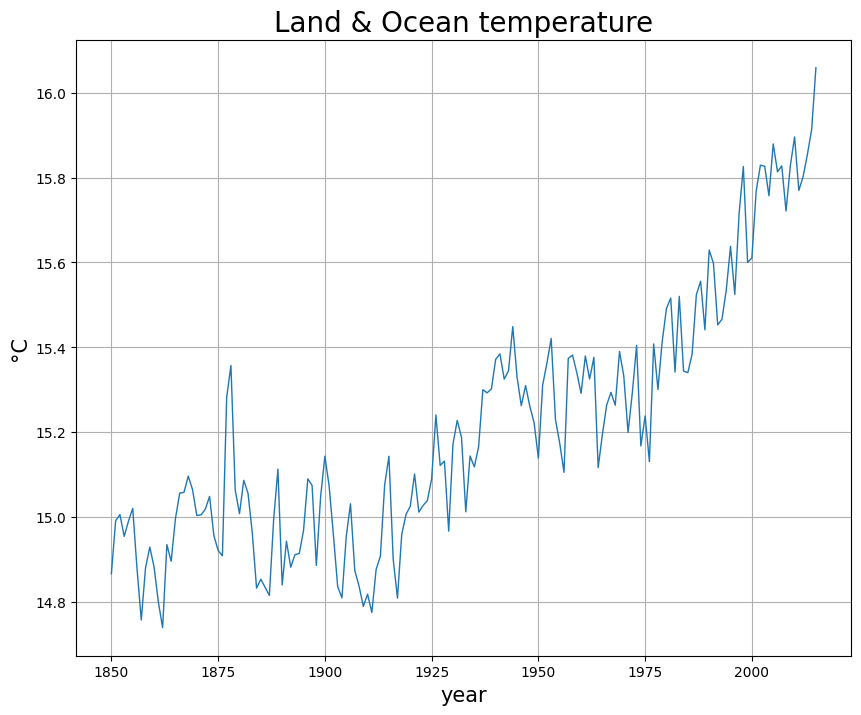

In [12]:
# Plot the year average temperature

avgTemp = global_data.groupby(global_data.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperature"].plot(linewidth=1)
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.grid(True)


In [13]:
prediction_series = pd.DataFrame(data=global_data['LandAndOceanAverageTemperature'])
prediction_series.index = global_data.index
prediction_series.head(5)

,LandAndOceanAverageTemperature
dt,
1850-01-01,12.833
1850-02-01,13.588
1850-03-01,14.043
1850-04-01,14.667
1850-05-01,15.507


In [14]:
model = auto_arima(prediction_series['LandAndOceanAverageTemperature'], 
                       start_p=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       m=12,
                       seasonal=True,
                       d=1,
                       D=1,
                       trend = 'ct',
                       test = 'adf',
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-2298.081, Time=8.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1171.890, Time=0.93 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1913.215, Time=5.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2341.233, Time=6.77 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-1491.875, Time=1.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-2251.439, Time=7.69 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-2367.718, Time=16.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-2370.128, Time=17.22 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-2343.297, Time=21.47 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-2219.171, Time=12.74 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2053.837, Time=14.85 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-2412.662, Time=21.32 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-2408.950, Time=18.19 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-2387.719, Time=21.81 s

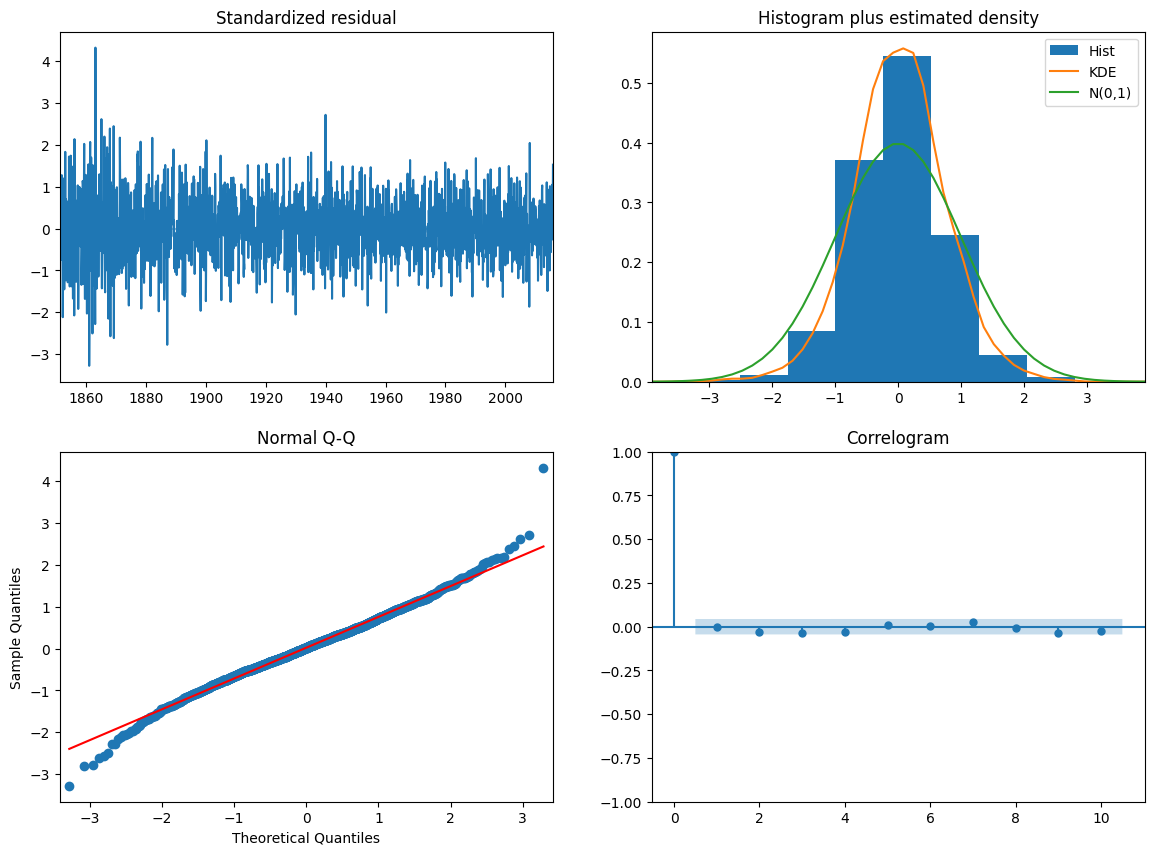

In [15]:
# Show diagnosis parameters
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [16]:
mod = sm.tsa.SARIMAX(prediction_series['LandAndOceanAverageTemperature'],order=(2,1,2),seasonal_order=(1, 1, 2, 12),trend='ct')
results = mod.fit()

print(results.summary())

/Users/dennisshushack/Documents/IVDApreprocessing/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/dennisshushack/Documents/IVDApreprocessing/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.17518D-01    |proj g|=  1.99633D+04


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/dennisshushack/Documents/IVDApreprocessing/env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     46      2     0     0   1.733D+04  -6.176D-01
  F = -0.61759343423112123     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                     SARIMAX Results                                      
Dep. Variable:     LandAndOceanAverageTemperature   No. Observations:                 1992
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                1230.246
Date:                            Fri, 09 Dec 2022   AIC                          -2440.492
Time:                                    14:52:40   BIC    

In [19]:
startDate = prediction_series.index[0]
endDate = prediction_series.index[-1]
predicted = results.predict(start=startDate, end=endDate)
prediction_series['LandAndOceanAverageTemperaturePredictions'] = predicted

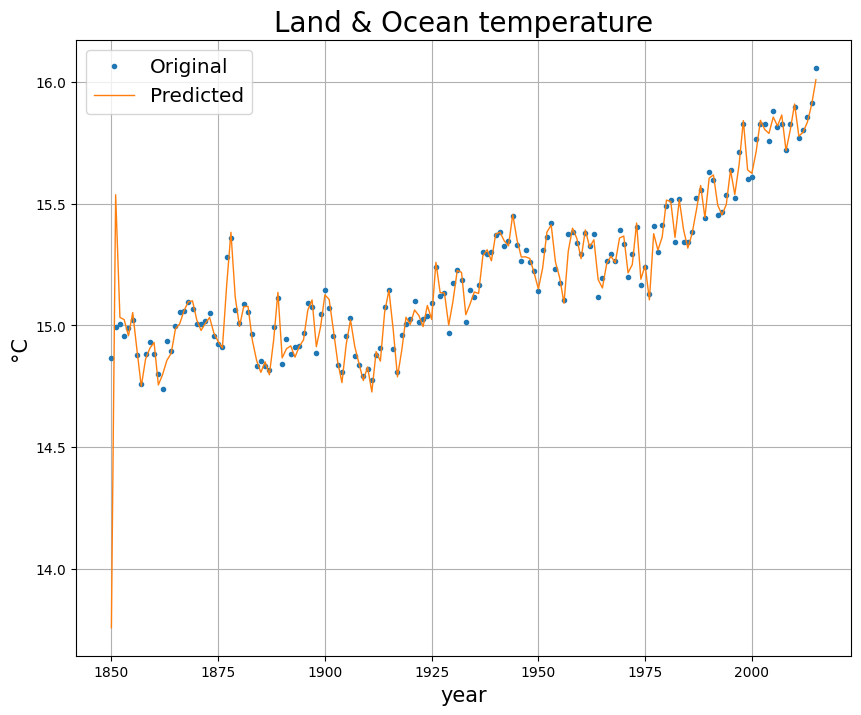

In [20]:
avgTemp = prediction_series.groupby(prediction_series.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperature"].plot(marker='.', linestyle="None", label='Original')
avgTemp["LandAndOceanAverageTemperaturePredictions"].plot(linewidth=1, label='Predicted')
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize='x-large')
plt.grid(True)

In [24]:

nbStep = (2050 - 2015) * 12
forecast = results.get_forecast(steps=nbStep)
# Return the predictions
results_dataframe = forecast.summary_frame()
forecast = results_dataframe['mean'].values
dates = results_dataframe.index.values

In [25]:
forecast

array([14.48014148, 14.68267277, 15.3716551 , 16.23996129, 16.99736991,
       17.59275581, 17.84778942, 17.80793654, 17.21519208, 16.33062744,
       15.32221919, 14.66872862, 14.49167867, 14.73124158, 15.4207558 ,
       16.27574871, 17.04248396, 17.64346526, 17.90058287, 17.8553392 ,
       17.26836052, 16.39241092, 15.39066689, 14.74448046, 14.55503094,
       14.78519144, 15.48311365, 16.34513422, 17.10891248, 17.70579062,
       17.96264941, 17.9198672 , 17.33008297, 16.4489937 , 15.44372299,
       14.79328106, 14.61091544, 14.84628822, 15.53954409, 16.39757977,
       17.16305405, 17.7622248 , 18.01924976, 17.97508049, 17.38688785,
       16.50869033, 15.50541383, 14.85736994, 14.67103272, 14.90348325,
       15.59937286, 16.45965798, 17.22418969, 17.82208207, 18.07902503,
       18.0356469 , 17.44657163, 16.56676077, 15.56237603, 14.91299718,
       14.72890621, 14.96301342, 15.65743682, 16.51647214, 17.28154887,
       17.88017542, 18.13718042, 18.09337386, 17.5048115 , 16.62

In [27]:
import pickle as pkl

# Save the model to pickle file
pkl.dump(results, open('./models/sarima.pkl', 'wb'))

### Yearly CSV

In [108]:
# Seperate the dt column into year and month and day:
global_data['year'] = pd.DatetimeIndex(global_data['dt']).year

# Remove the dt column
global_data = global_data.drop(['dt'], axis=1)

# Group the data by year and take the mean of the values
global_data = global_data.groupby('year').mean()

# Save the data in the processed folder as a csv file with the name global_temperatures_yearly.csv with the index year
global_data.to_csv('./processed/global_temperatures_yearly.csv', index=True)



### Preprocessing the country level data

In [109]:
country_data = pd.read_csv('./raw/GlobalLandTemperaturesByCountry.csv')

# Drop all rows where dt < 1850
country_data = country_data[country_data.dt >= '1850-01-01']

# Divde the dt column into year, month:
country_data['year'] = pd.DatetimeIndex(country_data['dt']).year
country_data['month'] = pd.DatetimeIndex(country_data['dt']).month

country_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month
1274,1850-01-01,-9.083,1.834,Åland,1850,1
1275,1850-02-01,-2.309,1.603,Åland,1850,2
1276,1850-03-01,-4.801,3.033,Åland,1850,3
1277,1850-04-01,1.242,2.008,Åland,1850,4
1278,1850-05-01,7.920,0.881,Åland,1850,5


In [110]:
# We will now create a loop to fill in the missing values for each country
# We will use the mean of a countries monthly temperature to fill in the missing values
import warnings
warnings.filterwarnings('ignore')

end_dataframe = pd.DataFrame()

for country in country_data['Country'].unique():
    # Subdataframe for each country:
    sub_df = country_data[country_data['Country'] == country]

    # Iterate over months:
    for month in sub_df['month'].unique():
        # Subdataframe for each month:
        sub_df_month = sub_df[sub_df['month'] == month]

        # Check if there are missing values:
        if sub_df_month['AverageTemperature'].isnull().values.any():
            # Fill in the missing values with the mean of the month:
            sub_df_month['AverageTemperature'] = sub_df_month['AverageTemperature'].fillna(sub_df_month['AverageTemperature'].mean())

            # Fill in the missing values with the mean of the month in AverageTemperatureUncertainty:
            sub_df_month['AverageTemperatureUncertainty'] = sub_df_month['AverageTemperatureUncertainty'].fillna(sub_df_month['AverageTemperatureUncertainty'].mean())

        # Append the subdataframe to the end dataframe:
        end_dataframe = end_dataframe.append(sub_df_month)



In [111]:
# Drop dt, and month column:
end_dataframe = end_dataframe.drop(['dt', 'month'], axis=1)

# Group the data by year and country and take the mean of the values
end_dataframe = end_dataframe.groupby(['year', 'Country']).mean()

# Reset the index
end_dataframe = end_dataframe.reset_index(drop=False)

end_dataframe.head()


,year,Country,AverageTemperature,AverageTemperatureUncertainty
0,1850,Afghanistan,13.326083,1.961917
1,1850,Africa,23.465931,1.075934
2,1850,Albania,11.734667,1.427667
3,1850,Algeria,22.587333,1.707583
4,1850,Andorra,10.651750,1.386083


In [112]:
# Drop all countries, that contain (Europe) 
end_dataframe = end_dataframe[~end_dataframe['Country'].str.contains('\(Europe\)')]

# Rename Congo (Democratic Republic Of The) to Democratic Republic of the Congo
end_dataframe['Country'] = end_dataframe['Country'].replace('Congo (Democratic Republic Of The)', 'Democratic Republic of the Congo')

# Drop all rows with the country Antarctica
end_dataframe = end_dataframe[end_dataframe['Country'] != 'Antarctica']
end_dataframe = end_dataframe[end_dataframe['Country'] != 'Congo']
end_dataframe = end_dataframe[end_dataframe['Country'] != 'Gaza Strip']


In [113]:
# Change the name of United States to United States of America
end_dataframe['Country'] = end_dataframe['Country'].replace('United States', 'United States of America')

# Load the country codes:
country_codes = pd.read_csv('./raw/alpha3.csv')

# Drop all rows beside the country name and the alpha3 code
country_codes = country_codes[['Country', 'alpha3']]

# Create a dictionary with the country name as key and the alpha3 code as a string
country_codes_dict = country_codes.set_index('Country')['alpha3'].to_dict()

# Add alpha3 codes of Baker Island
country_codes_dict['Baker Island'] = 'BKI'

# Add alpha3 codes of Howland Island Bonaire, Saint Eustatius And Saba
country_codes_dict['Howland Island'] = 'HWO'

# Add alpha3 codes of Saint Barthélemy
country_codes_dict['Saint Barthélemy'] = 'BLM'

# Add alpha3 codes of Kingman Reef
country_codes_dict['Kingman Reef'] = 'KMR'

# Add alpha3 codes of Bonaire, Saint Eustatius And Saba
country_codes_dict['Bonaire, Saint Eustatius And Saba'] = 'BES'

# Add alpha3 codes of Heard Island And Mcdonald Islands
country_codes_dict['Heard Island And Mcdonald Islands'] = 'HMD'

In [114]:
# Create a new column with the alpha3 code
end_dataframe['alpha3'] = end_dataframe['Country'].map(country_codes_dict)

In [115]:
# Show the unique countries that are missing an alpha3 code
end_dataframe[end_dataframe['alpha3'].isnull()]['Country'].unique()

array(['Africa', 'Asia', 'Europe', 'North America', 'South America',
       'Oceania'], dtype=object)

In [116]:
# Show head of the data
end_dataframe.head()

,year,Country,AverageTemperature,AverageTemperatureUncertainty,alpha3
0,1850,Afghanistan,13.326083,1.961917,AFG
1,1850,Africa,23.465931,1.075934,NaN
2,1850,Albania,11.734667,1.427667,ALB
3,1850,Algeria,22.587333,1.707583,DZA
4,1850,Andorra,10.651750,1.386083,AND


In [117]:
# Save the data in the processed folder as a csv file with the name country_yearly.csv:
end_dataframe.to_csv('./processed/country_yearly.csv', index=False)

In [118]:
# See the temperatures in Switzerland
end_dataframe[end_dataframe['Country'] == 'Switzerland']

,year,Country,AverageTemperature,AverageTemperatureUncertainty,alpha3
165,1850,Switzerland,6.151583,1.429833,CHE
359,1851,Switzerland,6.036167,1.584333,CHE
555,1852,Switzerland,7.232000,1.338083,CHE
753,1853,Switzerland,5.971500,1.116083,CHE
951,1854,Switzerland,6.532333,1.393667,CHE
...,...,...,...,...,...
37846,2009,Switzerland,8.300667,0.202250,CHE
38089,2010,Switzerland,7.226500,0.202250,CHE
38332,2011,Switzerland,8.847333,0.242667,CHE
38575,2012,Switzerland,8.159250,0.316417,CHE


In [119]:
# Read in the events data
events = pd.read_csv('./raw/events.csv')
events.head()

,Event name,Start,End,Description,Image,Source,Type
0,1st Industrial Revolution,1760,1820,The Industrial Revolution was the transition t...,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Industrial_Revol...,NaN
1,The American Revolution,1765,1783,The American Revolution was an ideological and...,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/American_Revolution,NaN
2,Grímsvötn Eruption,1783,1783,Grímsvötn is a volcano located under the Vatna...,https://volcano.si.edu/gallery/photos/GVP-1119...,https://volcano.si.edu/volcano.cfm?vn=373010,NaN
3,The French Revolution,1789,1799,The French Revolution was a period of radical ...,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/French_Revolution,NaN
4,Dalton Minimum,1790,1830,The Dalton Minimum was a period of low sunspot...,https://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Dalton_Minimum,NaN
